In [4]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

# Experimental information

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  anti-His tag spots: All of the recombinant proteins that are used to coat the plates have hexa-His tags cloned into them, and the coat protein in these spots is anti-His. In this experiment, all of the recombinant antigens were spotted here on the anti-His coated spot, then serum was added so that the spot is representative of a polyclonal response. There was more cross-reactivity than expected and **this control will not be used in the future covid plates.**

# Data format conventions

For ease of reading and manipulating data, all data is converted in $n$-dimensional arrays. 
* Well metadata is #wells $\times$ 4 array. 
* antigen metadata is  #rows $\times$ #columns in the array.
* background corrected ODs is a 4D float array (Well row x Well column x Array row x Array column).

# TODO

####  All methods/transformations should use simple data structures, e.g., use numpy array as input and generate numpy array as output.

* defs: 
    * read_data: parse csv and xls to return array of well information, antigen information, and antigenODs.
    * plot_OD(antigen, sera, dilutions), antigen can be fiducial, positive control, negative control, or diagnostic. 
    * compareODs(antigens,sera), plots to compare ODs (antibody amount) across sera
    * estimateTiter(antigen, serum) dilution at which antigen becomes undetectable in given serum
 

# Read identity of wells and antigen spots in 2D arrays

In [14]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=os.path.join(data_folder,'interpolationODs.xlsx') #change this for flu plate when available

In [8]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate'
plateinfo_path=os.path.join(data_folder,'PlateInfoFLuplate.csv')
antigenOD_path=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-03-30-15-08-05-COVD_March25_fluplatetest_AdamsPlate/test_output/⁨3_31_18_7_10⁩/ODs.xlsx' #change this for flu plate when available



In [15]:
plateinfo_dataframe=pd.read_csv(plateinfo_path)
plateInfo=plateinfo_dataframe.to_numpy()
pprint(plateInfo)

array([['A1', 'HumanReferencePlasma', 'Control', 1.0],
       ['A2', 'anti-HA mAb MEDI8852', 'Control', 1.0],
       ['A3', 'antii-HA mAb TF19', 'Control', 1.0],
       ['A4', 'MS-Day0', 'Diagnostic', 0.001],
       ['A5', 'MS-Day7', 'Diagnostic', 0.001],
       ['A6', 'MS-Day14', 'Diagnostic', 0.001],
       ['A7', 'MS-Day21', 'Diagnostic', 0.001],
       ['A8', '005-18-Day0', 'Diagnostic', 0.001],
       ['A9', '005-18-Day7', 'Diagnostic', 0.001],
       ['A10', '005-18-Day18', 'Diagnostic', 0.001],
       ['A11', '006-Day7', 'Diagnostic', 0.001],
       ['A12', 'AssayDiluentControl', 'Control', 1.0],
       ['B1', 'HumanReferencePlasma', 'Control', 0.25],
       ['B2', 'anti-HA mAb MEDI8852', 'Control', 0.25],
       ['B3', 'antii-HA mAb TF19', 'Control', 0.25],
       ['B4', 'MS-Day0', 'Diagnostic', 0.00025],
       ['B5', 'MS-Day7', 'Diagnostic', 0.00025],
       ['B6', 'MS-Day14', 'Diagnostic', 0.00025],
       ['B7', 'MS-Day21', 'Diagnostic', 0.00025],
       ['B8', '005-18-Day0

In [16]:
converter = {col: str for col in range(0,7)}
antigens_dataframe=pd.read_excel(antigenOD_path, sheet_name='antigens', converters=converter)
antigens=antigens_dataframe.to_numpy()[:,1:] 
pprint(antigens)

array([[nan, 'Flu vaccine 2018-2019', 'Flu vaccine 2018-2019',
        'Flu vaccine 2018-2019', 'Flu vaccine 2018-2019', nan],
       [nan, 'H1 HA', 'H1 HA', 'H1 HA', 'H1 HA', nan],
       [nan, 'H3 HA', 'H3 HA', 'H3 HA', 'H3 HA', nan],
       [nan, 'H7 HA', 'H7 HA', 'H7 HA', 'H7 HA', nan],
       [nan, 'HA FluB I', 'HA FluB I', 'HA FluB I', 'HA FluB I', nan],
       [nan, 'HA FluB II', 'HA FluB II', 'HA FluB II', 'HA FluB II', nan]],
      dtype=object)


# Read ODs of all wells in a 4D array (Well row x Well column x Array row x Array column)

## Read data

In [19]:
row_label=['A','B','C','D','E','F','G','H']
col_label=[str(idx) for idx in np.arange(12)+1]
antigenOD=np.empty((8,12,6,6)) # 96 wells, 6 antigen rows, 8 antigen columns
wellID=np.empty((8,12),dtype=object)

In [20]:
# Read all wells into dictionary and into a 4D numpy array.
for r in np.arange(8):
    for c in np.arange(12):
        well_key = row_label[r]+col_label[c]
        antigenOD_dataframe=pd.read_excel(antigenOD_path, sheet_name=well_key)
        antigenOD[r,c,:,:]=antigenOD_dataframe.to_numpy()[:,1:] # First column is simply the index. to_numpy returns 6x9 array.
        wellID[r,c] = well_key

## how to index the OD data.

#### direct indexing

In [21]:
pprint(antigenOD[0,0]) # Well A1

array([[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
        1.3063261 ],
       [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
        0.97001301],
       [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
        1.01487095],
       [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
        1.01577171],
       [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
        1.01984698],
       [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
        1.13418449]])


In [9]:
pprint(antigenOD[0,3]) # well A4

array([[1.43988273, 1.3451414 , 2.99774562, 1.21434209, 1.29873839,
        1.08886344, 1.23414691, 1.61283121],
       [1.44550936, 1.15400541, 2.96651674, 1.26165007, 1.09079668,
        1.081295  , 1.06818851, 3.55750328],
       [1.87884234, 1.28353302, 1.11147366, 1.20569399, 1.07842211,
        1.03519571, 1.13637536, 1.10705243],
       [1.93024336, 1.06879314, 1.16157532, 1.11076694, 1.08172383,
        1.04190418, 1.11740187, 1.08562124],
       [1.74705778, 1.05420597, 1.3725761 , 1.11878548, 1.1752757 ,
        1.0787549 , 1.05155942, 1.00879728],
       [1.44784659, 1.06575727, 1.30663138, 1.23790682, 1.07855464,
        1.06769399, 1.05361099, 1.40577401]])


#### logical indexing

In [22]:
pprint(antigenOD[wellID == 'A4'])

array([[[1.51057438, 1.72730503, 1.60149197, 1.63297109, 1.5686067 ,
         1.32212619],
        [1.39139012, 1.19648487, 1.17148837, 1.17381992, 1.1895725 ,
         0.9799163 ],
        [1.55854897, 1.24260422, 1.21974564, 1.20463072, 1.24338333,
         1.04502998],
        [1.56578046, 1.08637737, 1.04226942, 1.03899924, 1.01072581,
         1.05024331],
        [1.57689151, 2.25824464, 1.95320697, 1.86113774, 2.05701918,
         1.04949529],
        [1.46018973, 2.25584258, 1.96541285, 1.9000124 , 2.00442124,
         1.40289936]]])


In [23]:
pprint(antigenOD[wellID == 'A1'])

array([[[1.36503811, 1.5155178 , 1.45785232, 1.44306173, 1.38163254,
         1.3063261 ],
        [1.30002172, 1.61077511, 1.56254699, 1.53840071, 1.55704935,
         0.97001301],
        [1.52734561, 1.08392779, 1.08187972, 1.06285456, 1.05726947,
         1.01487095],
        [1.38300153, 1.1188896 , 1.08965004, 1.07749847, 1.11146203,
         1.01577171],
        [1.23516534, 1.61545466, 1.48470893, 1.440994  , 1.60285462,
         1.01984698],
        [1.11721243, 1.44748857, 1.26443018, 1.3972606 , 1.34868749,
         1.13418449]]])


# Plot standard curve.

In [24]:
# Prepare arrays for logical indexing.
# Logical indexing works only for numpy array only not the standard python lists.

wellIdx = np.array([row+str(col) for row in ['A','B','C','D','E','F','G','H'] for col in range(1,13)])
wellmetaIdx=np.array(['Well','SeraID','Type','Concentration'])
antigenIdx = antigens.flatten()

# Transform antigenODs to wellxspot structure.
ODwellbyantigen=antigenOD.reshape(len(wellIdx),len(antigenIdx))
#pprint(wellIdx)
#pprint(antigenIdx)

## Find concentrations in control wells

#The control wells in this plate are in columns, not rows, so this is reflected below. A2-H2 is an anti-HA antibody against spots in the top spot row, A3-H3 is an anti-HA antibody against spots in the top spot row and bottom spot row. Column 12 of the plate contains an assay diluent control.

In [53]:
controlWells = []
for row in ['A','B','C','D','E','F','G','H']:
    wellsinthisrow = [row+str(col) for col in range(2,4)]
    controlWells.append(wellsinthisrow)
pprint(controlWells)

[['A2', 'A3'],
 ['B2', 'B3'],
 ['C2', 'C3'],
 ['D2', 'D3'],
 ['E2', 'E3'],
 ['F2', 'F3'],
 ['G2', 'G3'],
 ['H2', 'H3']]


In [54]:
controlWells = np.reshape(controlWells,(1,16))

In [60]:
wellmetaIdx.shape

(4,)

In [65]:
controlWells.shape

(16,)

In [63]:
controlWells = np.reshape(controlWells,(16,))

In [62]:
wellIdx.shape

(96,)

In [64]:
controlConcentrations=np.concatenate([plateInfo[wellIdx == well, wellmetaIdx == 'Concentration'] for well in controlWells])
pprint(controlConcentrations)

array([1.0, 1.0, 0.25, 0.25, 0.0625, 0.0625, 0.015625, 0.015625,
       0.00390625, 0.00390625, 0.000976563, 0.000976563,
       0.00024414099999999997, 0.00024414099999999997, 6.10352e-05,
       6.10352e-05], dtype=object)


In [77]:
#Commenting this out in favor of the above cell for this plate
#controlWells=np.array(['H'+str(col) for col in range(2,10)])
#controlConcentrations= np.concatenate([plateInfo[wellIdx == well,wellmetaIdx == 'Concentration'] for well in controlWells])
#pprint(controlConcentrations)

In [66]:
for well in controlWells:
    print(well)

A2
A3
B2
B3
C2
C3
D2
D3
E2
E3
F2
F3
G2
G3
H2
H3


In [67]:

concentrationsAll = np.array([float(strconc) for strconc in controlConcentrations])
pprint(concentrationsAll)

array([1.00000e+00, 1.00000e+00, 2.50000e-01, 2.50000e-01, 6.25000e-02,
       6.25000e-02, 1.56250e-02, 1.56250e-02, 3.90625e-03, 3.90625e-03,
       9.76563e-04, 9.76563e-04, 2.44141e-04, 2.44141e-04, 6.10352e-05,
       6.10352e-05])


In [68]:
concentrations=concentrationsAll[1::2]
pprint(concentrations)

array([1.00000e+00, 2.50000e-01, 6.25000e-02, 1.56250e-02, 3.90625e-03,
       9.76563e-04, 2.44141e-04, 6.10352e-05])


In [74]:
controlWellsMEDI=controlWells[0::2]
pprint(controlWellsMEDI)

array(['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2'], dtype='<U2')


In [89]:
#Commenting this out in favor of the above cells for this plate
#concentrations=np.array([float(strconc[0:-2]) for strconc in controlConcentrations]) 

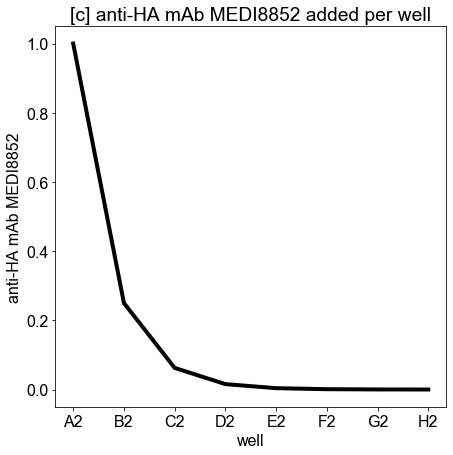

In [69]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, lw=4, c='k')
plt.xticks(ticks=np.arange(len(concentrations)),labels=controlWells[0::2])
plt.xlabel('well')
plt.ylabel('anti-HA mAb MEDI8852')
plt.title('[c] anti-HA mAb MEDI8852 added per well');
#The plot for anti-HA mAb TF19 will look the same as this one, same concentrations per well but A3

## OD of xkappa-biotin should not change with concentration.

In [70]:
# Extract ODs across control wells and over all spots.
xkappaOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xkappa-biotin'] for well in controlWells])
xkappaODMean=np.mean(xkappaOD, axis =1)

/opt/miniconda3/envs/serology/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/serology/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


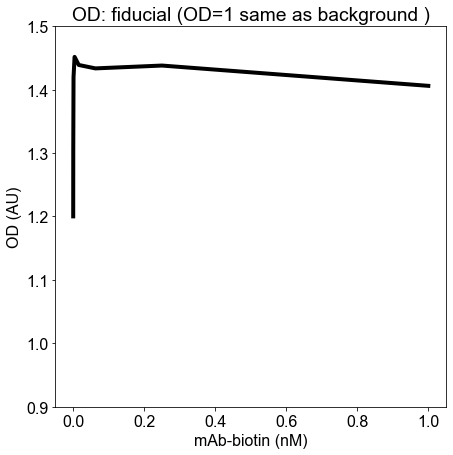

In [104]:
plt.figure(figsize=(7,7))
plt.plot(concentrations, xkappaODMean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)') #The flu plate does not have mAb-biotin, determine how this should change
plt.ylabel('OD (AU)')
plt.title('OD: fiducial (OD=1 same as background )');

## OD of GFP-foldon (-ve control) should be lower than fiducial

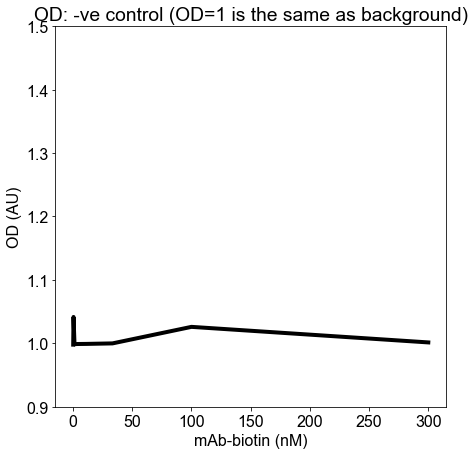

In [30]:
GFPfoldonOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'GFP-foldon'] for well in controlWells])
GFPfoldonODmean=np.mean(GFPfoldonOD, axis =1)
plt.figure(figsize=(7,7))
plt.plot(concentrations, GFPfoldonODmean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: -ve control (OD=1 is the same as background)');

## OD of  (+ve control) should be higher than fiducial

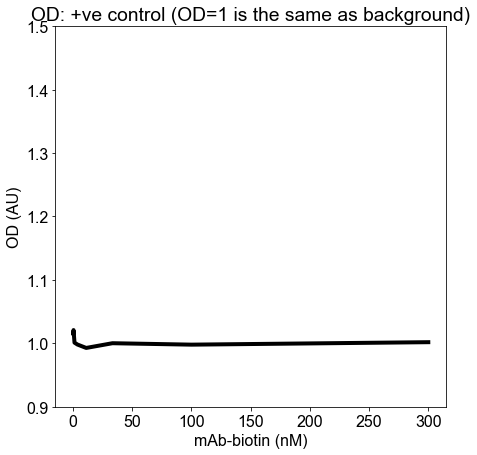

In [31]:
xmouseIgGOD=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'xmouse-IgG'] for well in controlWells])
xmouseIgGODmean=np.mean(xmouseIgGOD, axis =1)
plt.figure(figsize=(7,7))
plt.plot(concentrations, xmouseIgGODmean, lw=4, c='k')
plt.ylim([0.9,1.5])
plt.xlabel('mAb-biotin (nM)')
plt.ylabel('OD (AU)')
plt.title('OD: +ve control (OD=1 is the same as background)');

## +ve control didn't seem to work, let's look at images. 
spot 2-8 in raw data is +ve control (xmouse-IgG), and spot 5-8 is -ve control (GFP foldon). Plots match the data

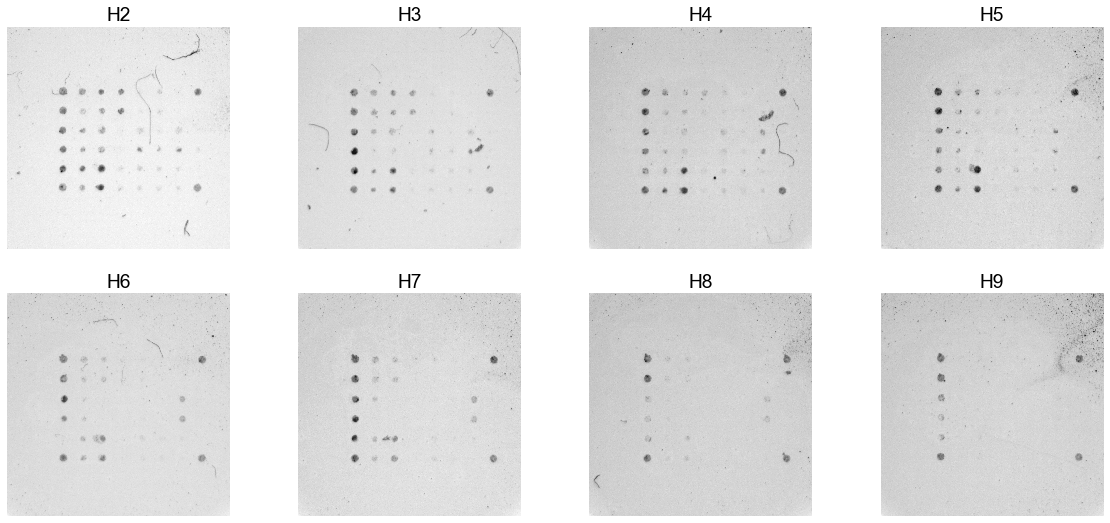

In [32]:
fig, ax = plt.subplots(2,int(len(controlWells)/2),figsize=(20,9))
ax=ax.flatten()
for n in range(8):
    wellImg=io.imread(os.path.join(data_folder,'20200327_analyzedPlate',controlWells[n]+'_crop.png'))
    ax[n].imshow(wellImg,cmap='gray')
    ax[n].set_title(controlWells[n])             
    ax[n].axis('off')

In [105]:
## Plot a standard curve using information from anti-HA mAb MEDI8852 wells

## Let's look at spot 16061 which shows some dynamic range over H1..H9.

In [75]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])
pprint(antigenvaccine)

array([[1.29361701, 1.28230958, 1.26620668, 1.28148715],
       [1.22413749, 1.25108522, 1.26219094, 1.26221479],
       [1.23226354, 1.21985598, 1.24805682, 1.26364718],
       [1.1328589 , 1.12572158, 1.11748446, 1.12382501],
       [1.07654113, 1.07959817, 1.08066351, 1.07320915],
       [1.01554702, 1.02020619, 1.01955793, 1.01968565],
       [1.00726404, 1.00590698, 1.00645212, 1.00599513],
       [1.00224073, 1.00265987, 1.00239297, 1.00151115]])


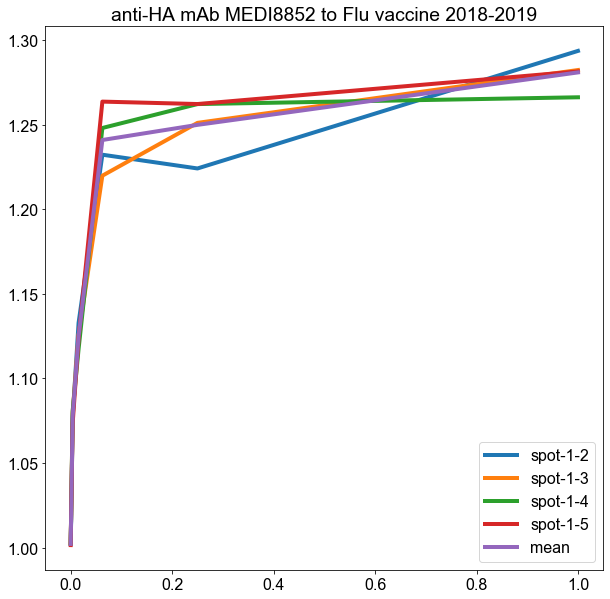

In [77]:
antigenvaccine=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in controlWellsMEDI])

plt.figure(figsize=(10,10))
plt.plot(concentrations,antigenvaccine,concentrations,np.mean(antigenvaccine,axis=1),lw=4 );
plt.legend(['spot-1-2','spot-1-3','spot-1-4','spot-1-5','mean'])
plt.title('anti-HA mAb MEDI8852 to Flu vaccine 2018-2019');


## Fit a 4PL to mean values from anti-HA mAB MEDI8852 to vaccine spots

In [135]:
concentrations2=[300,
75,
18.75,
4.6875,
1.171875,
0.29296875,
0.073242188,
0.018310547]
concentrations2=np.flip(concentrations2)
pprint(concentrations2)

array([1.8310547e-02, 7.3242188e-02, 2.9296875e-01, 1.1718750e+00,
       4.6875000e+00, 1.8750000e+01, 7.5000000e+01, 3.0000000e+02])


In [168]:
flippedmeans=np.flip(np.mean(antigenvaccine,axis=1))

<ipython-input-169-4a0db459b974>:5: RuntimeWarning: invalid value encountered in power
  return ((A-D)/(1.0+((x/C)**(B))) + D)


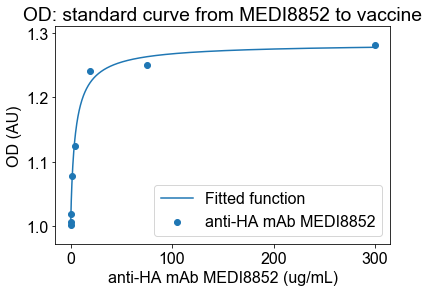

In [169]:
import scipy.optimize as optimization
xdata = concentrations2
ydata = flippedmeans
def fourPL(x, A, B, C, D):
    return ((A-D)/(1.0+((x/C)**(B))) + D)

guess = [0, -0.5, 0.5, 1]
params, params_covariance = optimization.curve_fit(fourPL, xdata, ydata, guess)#, maxfev=1)

x_min, x_max = np.amin(xdata), np.amax(xdata)
xs = np.linspace(x_min, x_max, 1000)
plt.scatter(xdata, ydata, label='anti-HA mAb MEDI8852')
plt.plot(xs, fourPL(xs, *params), label='Fitted function')
plt.legend(loc='best')
plt.xlabel('anti-HA mAb MEDI8852 (ug/mL)')
plt.ylabel('OD (AU)')
plt.title('OD: standard curve from MEDI8852 to vaccine');
plt.show()

#The concentration of MEDI8852 starts at 300 ug/mL (or 10x), so we can add that to the plot for interpolation

In [157]:
testOD = 1.23 #This is just a test value
testODAbConc=(C*((((A-D)/(testOD-D))-1)**(1/B))) #interpolate into fitted curve
pprint(testODAbConc)

3.428811849878588


In [153]:
pprint(params)

array([ 1.00088847, -0.90686158,  1.18694846,  1.28376871])


In [167]:
def getConcentration(ODs,params):
    return (C*((((A-D)/(ODs-D))-1)**(1/B))) #interpolate into fitted curve

In [163]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
H1HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day0])
H3HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day0])
H7HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day0])
HAFluBIIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day0])

# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay0=np.mean(H1HAMSDay0,axis=1)
mH3HAMSDay0=np.mean(H3HAMSDay0,axis=1)
mH7HAMSDay0=np.mean(H7HAMSDay0,axis=1)
mHAFluBIMSDay0=np.mean(HAFluBIMSDay0,axis=1)
mHAFluBIIMSDay0=np.mean(HAFluBIMSDay0,axis=1)

allMeans=[mFluVaccineMSDay0,mH1HAMSDay0, mH3HAMSDay0,mH7HAMSDay0,mHAFluBIMSDay0,mHAFluBIIMSDay0]
pprint(allMeans)

allConcentrations=getConcentration(allMeans,params)
pprint(allConcentrations)


[array([1.6325937 , 1.24057201, 1.12274793, 1.04168365, 1.00825405,
       1.0023307 , 0.99973903, 1.03495   ]),
 array([1.18284141, 1.05365641, 1.01095905, 0.99956109, 0.99464464,
       0.99662646, 0.99682175, 0.99788761]),
 array([1.22759098, 1.08346679, 1.01743137, 1.00075848, 0.99729104,
       0.99765584, 0.99699758, 0.99808423]),
 array([1.04459296, 1.00691867, 1.00022285, 0.99342826, 0.99325535,
       0.99510629, 0.9959808 , 0.99560323]),
 array([2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
       0.99815258, 0.99566044, 0.99736447]),
 array([2.03240213, 1.31247131, 1.17488615, 1.06124772, 1.00449509,
       0.99815258, 0.99566044, 0.99736447])]


TypeError: unsupported operand type(s) for -: 'list' and 'float'

## Compare antibody response against all antigens for one collection day of MS serum

In [143]:
dilutions= [0,1,2,3,4,5,6,7]
pprint(dilutions)

[0, 1, 2, 3, 4, 5, 6, 7]


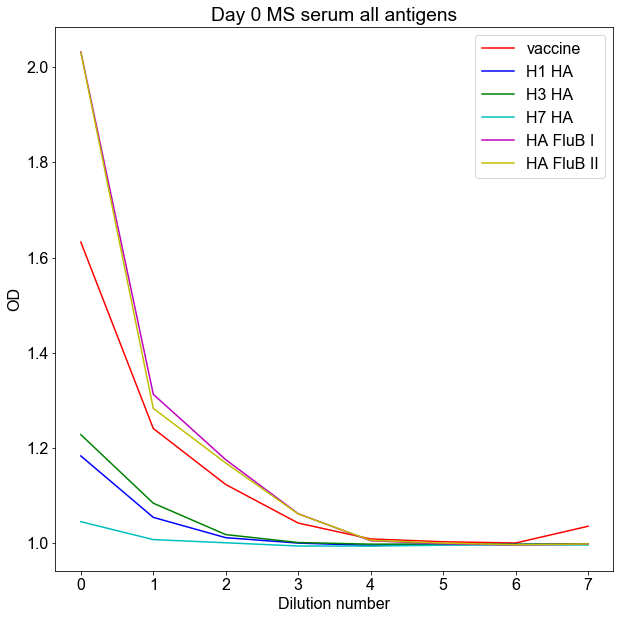

In [165]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
H1HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day0])
H3HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day0])
H7HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day0])
HAFluBIIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day0])

# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay0=np.mean(H1HAMSDay0,axis=1)
mH3HAMSDay0=np.mean(H3HAMSDay0,axis=1)
mH7HAMSDay0=np.mean(H7HAMSDay0,axis=1)
mHAFluBIMSDay0=np.mean(HAFluBIMSDay0,axis=1)
mHAFluBIIMSDay0=np.mean(HAFluBIIMSDay0,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay0,'r', dilutions,mH1HAMSDay0,'b',dilutions,mH3HAMSDay0, 'g', dilutions,mH7HAMSDay0,'c', dilutions,mHAFluBIMSDay0,'m', dilutions, mHAFluBIIMSDay0, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 0 MS serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


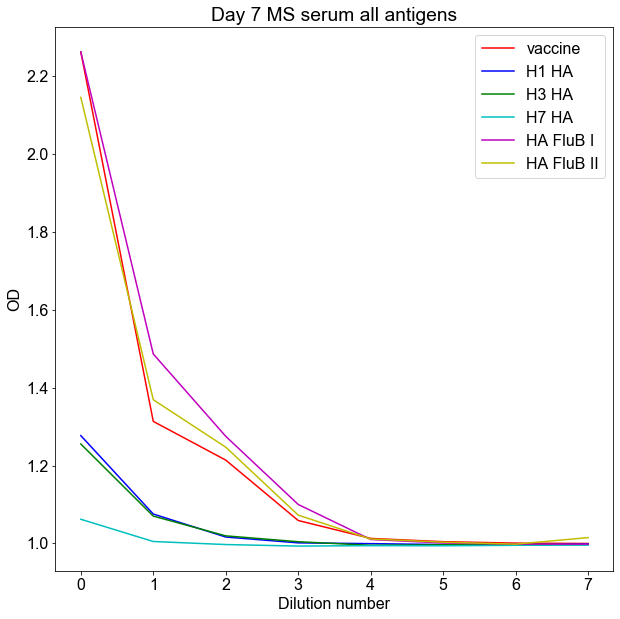

In [145]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day7])
H1HAMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day7])
H3HAMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day7])
H7HAMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day7])
HAFluBIMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day7])
HAFluBIIMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day7])

# Generate means per well
mFluVaccineMSDay7=np.mean(FluVaccineMSDay7,axis=1) # average within each well.
mH1HAMSDay7=np.mean(H1HAMSDay7,axis=1)
mH3HAMSDay7=np.mean(H3HAMSDay7,axis=1)
mH7HAMSDay7=np.mean(H7HAMSDay7,axis=1)
mHAFluBIMSDay7=np.mean(HAFluBIMSDay7,axis=1)
mHAFluBIIMSDay7=np.mean(HAFluBIIMSDay7,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay7,'r', dilutions,mH1HAMSDay7,'b',dilutions,mH3HAMSDay7, 'g', dilutions,mH7HAMSDay7,'c', dilutions,mHAFluBIMSDay7,'m', dilutions, mHAFluBIIMSDay7, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 7 MS serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


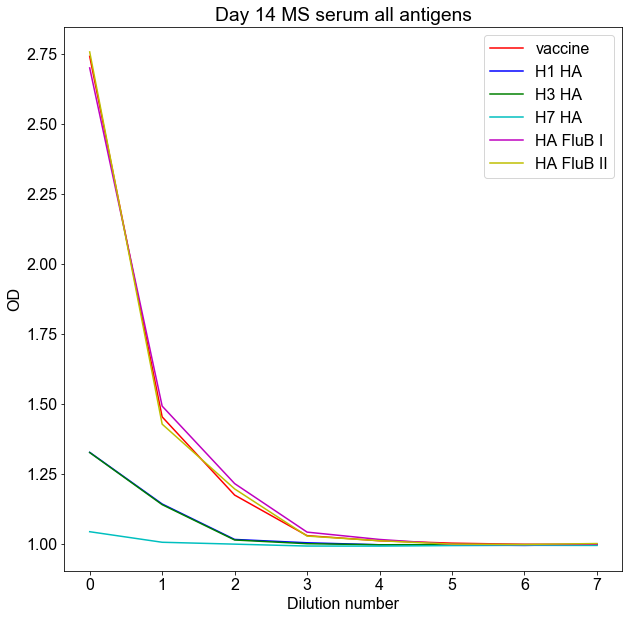

In [146]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day14])
H1HAMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day14])
H3HAMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day14])
H7HAMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day14])
HAFluBIIMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day14])

# Generate means per well
mFluVaccineMSDay14=np.mean(FluVaccineMSDay14,axis=1) # average within each well.
mH1HAMSDay14=np.mean(H1HAMSDay14,axis=1)
mH3HAMSDay14=np.mean(H3HAMSDay14,axis=1)
mH7HAMSDay14=np.mean(H7HAMSDay14,axis=1)
mHAFluBIMSDay14=np.mean(HAFluBIMSDay14,axis=1)
mHAFluBIIMSDay14=np.mean(HAFluBIIMSDay14,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay14,'r', dilutions,mH1HAMSDay14,'b',dilutions,mH3HAMSDay14, 'g', dilutions,mH7HAMSDay14,'c', dilutions,mHAFluBIMSDay14,'m', dilutions, mHAFluBIIMSDay14, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 14 MS serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


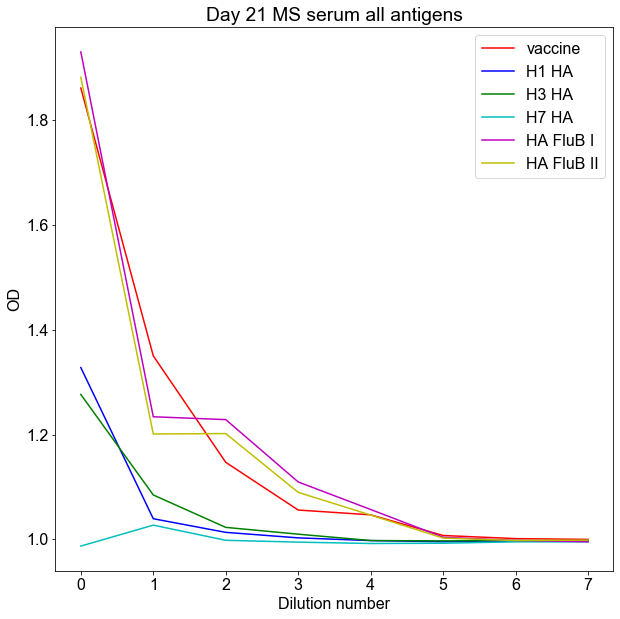

In [147]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4']
Day0=['A4','B4','C4','D4','E4','F4','G4','H4']
Day7=['A5','B5','C5','D5','E5','F5','G5','H5']
Day14=['A6','B6','C6','D6','E6','F6','G6','H6']
Day21=['A7','B7','C7','D7','E7','F7','G7','H7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day21])
H1HAMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day21])
H3HAMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day21])
H7HAMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day21])
HAFluBIMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day21])
HAFluBIIMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day21])

# Generate means per well
mFluVaccineMSDay21=np.mean(FluVaccineMSDay21,axis=1) # average within each well.
mH1HAMSDay21=np.mean(H1HAMSDay21,axis=1)
mH3HAMSDay21=np.mean(H3HAMSDay21,axis=1)
mH7HAMSDay21=np.mean(H7HAMSDay21,axis=1)
mHAFluBIMSDay21=np.mean(HAFluBIMSDay21,axis=1)
mHAFluBIIMSDay21=np.mean(HAFluBIIMSDay21,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay21,'r', dilutions,mH1HAMSDay21,'b',dilutions,mH3HAMSDay21, 'g', dilutions,mH7HAMSDay21,'c', dilutions,mHAFluBIMSDay21,'m', dilutions, mHAFluBIIMSDay21, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 21 MS serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


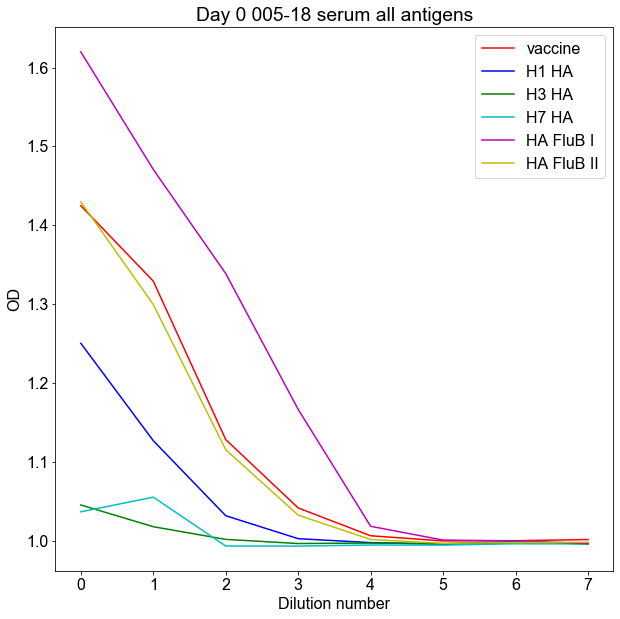

In [164]:
#All dilutions for each day
Day0=['A8','B8','C8','D8','E8','F8','G8','H8']
Day7=['A9','B9','C9','D9','E9','F9','G9','H9']
Day18=['A10','B10','C10','D10','E10','F10','G10','H10']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
H1HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day0])
H3HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day0])
H7HAMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day0])
HAFluBIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day0])
HAFluBIIMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day0])

# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay0=np.mean(H1HAMSDay0,axis=1)
mH3HAMSDay0=np.mean(H3HAMSDay0,axis=1)
mH7HAMSDay0=np.mean(H7HAMSDay0,axis=1)
mHAFluBIMSDay0=np.mean(HAFluBIMSDay0,axis=1)
mHAFluBIIMSDay0=np.mean(HAFluBIIMSDay0,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay0,'r', dilutions,mH1HAMSDay0,'b',dilutions,mH3HAMSDay0, 'g', dilutions,mH7HAMSDay0,'c', dilutions,mHAFluBIMSDay0,'m', dilutions, mHAFluBIIMSDay0, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 0 005-18 serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


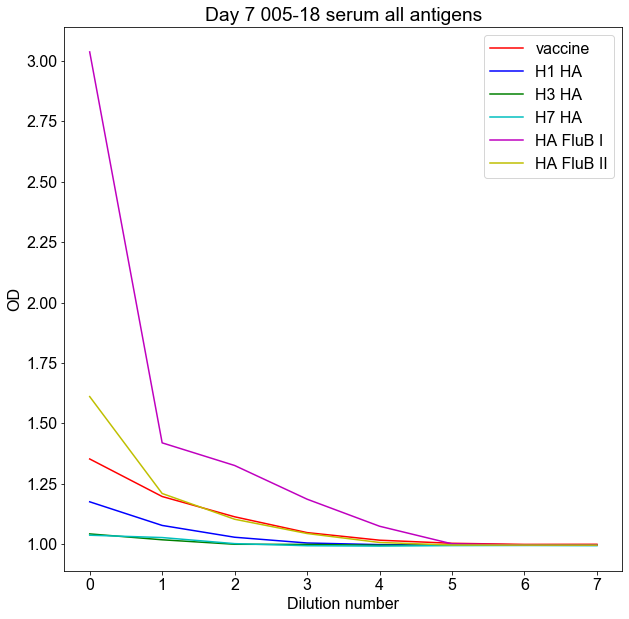

In [148]:
#All dilutions for each day
Day0=['A8','B8','C8','D8','E8','F8','G8','H8']
Day7=['A9','B9','C9','D9','E9','F9','G9','H9']
Day18=['A10','B10','C10','D10','E10','F10','G10','H10']



# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day7])
H1HAMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day7])
H3HAMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day7])
H7HAMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day7])
HAFluBIMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day7])
HAFluBIIMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day7])

# Generate means per well
mFluVaccineMSDay7=np.mean(FluVaccineMSDay7,axis=1) # average within each well.
mH1HAMSDay7=np.mean(H1HAMSDay7,axis=1)
mH3HAMSDay7=np.mean(H3HAMSDay7,axis=1)
mH7HAMSDay7=np.mean(H7HAMSDay7,axis=1)
mHAFluBIMSDay7=np.mean(HAFluBIMSDay7,axis=1)
mHAFluBIIMSDay7=np.mean(HAFluBIIMSDay7,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay7,'r', dilutions,mH1HAMSDay7,'b',dilutions,mH3HAMSDay7, 'g', dilutions,mH7HAMSDay7,'c', dilutions,mHAFluBIMSDay7,'m', dilutions, mHAFluBIIMSDay7, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 7 005-18 serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


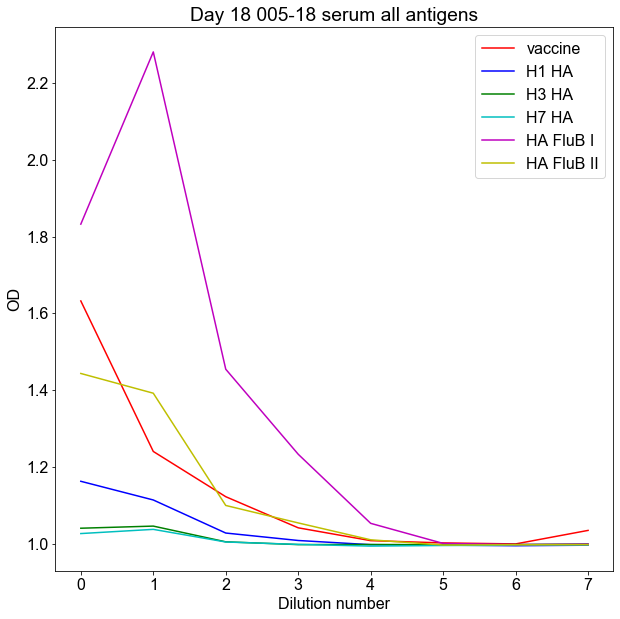

In [166]:
#All dilutions for each day
Day0=['A8','B8','C8','D8','E8','F8','G8','H8']
Day7=['A9','B9','C9','D9','E9','F9','G9','H9']
Day18=['A10','B10','C10','D10','E10','F10','G10','H10']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay18=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day18])
H1HAMSDay18=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H1 HA'] for well in Day18])
H3HAMSDay18=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H3 HA'] for well in Day18])
H7HAMSDay18=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'H7 HA'] for well in Day18])
HAFluBIMSDay18=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB I'] for well in Day18])
HAFluBIIMSDay18=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'HA FluB II'] for well in Day18])

# Generate means per well
mFluVaccineMSDay18=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mH1HAMSDay18=np.mean(H1HAMSDay18,axis=1)
mH3HAMSDay18=np.mean(H3HAMSDay18,axis=1)
mH7HAMSDay18=np.mean(H7HAMSDay18,axis=1)
mHAFluBIMSDay18=np.mean(HAFluBIMSDay18,axis=1)
mHAFluBIIMSDay18=np.mean(HAFluBIIMSDay18,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay18,'r', dilutions,mH1HAMSDay18,'b',dilutions,mH3HAMSDay18, 'g', dilutions,mH7HAMSDay18,'c', dilutions,mHAFluBIMSDay18,'m', dilutions, mHAFluBIIMSDay18, 'y')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 18 005-18 serum all antigens')
plt.legend(['vaccine', 'H1 HA', 'H3 HA', 'H7 HA', 'HA FluB I', 'HA FluB II'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


In [122]:
AllDays = [[Day0],[Day7],[Day14],[Day21]]
pprint(AllDays)

for day in AllDays

[[['A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4']],
 [['A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5']],
 [['A6', 'B6', 'C6', 'D6', 'E6', 'F6', 'G6']],
 [['A7', 'B7', 'C7', 'D7', 'E7', 'F7', 'G7']]]


## Compare antibody response to one antigen across multiple days (days 0, 7, 14, and 21)

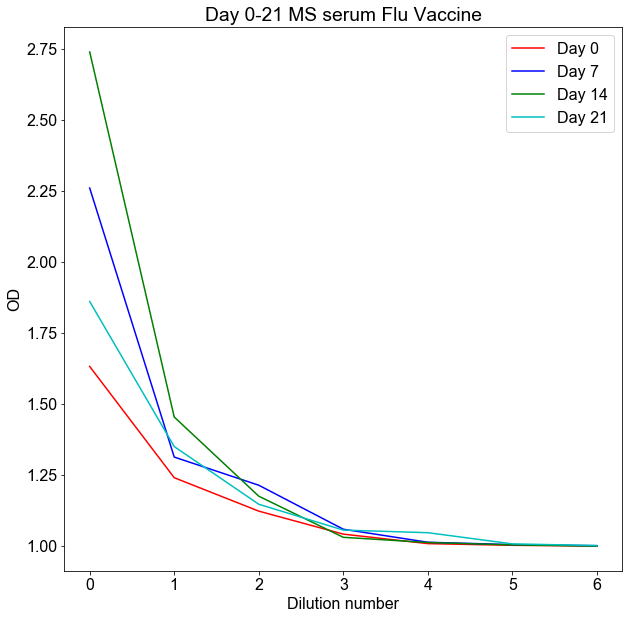

In [120]:
#All dilutions for each day
Day0=['A4','B4','C4','D4','E4','F4','G4']
Day7=['A5','B5','C5','D5','E5','F5','G5']
Day14=['A6','B6','C6','D6','E6','F6','G6']
Day21=['A7','B7','C7','D7','E7','F7','G7']


# Generate a stack of all ODs for an MS antibody response per antigen on Day0 
FluVaccineMSDay0=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day0])
FluVaccineMSDay7=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day7])
FluVaccineMSDay14=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day14])
FluVaccineMSDay21=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == 'Flu vaccine 2018-2019'] for well in Day21])


# Generate means per well
mFluVaccineMSDay0=np.mean(FluVaccineMSDay0,axis=1) # average within each well.
mFluVaccineMSDay7=np.mean(FluVaccineMSDay7,axis=1)
mFluVaccineMSDay14=np.mean(FluVaccineMSDay14,axis=1)
mFluVaccineMSDay21=np.mean(FluVaccineMSDay21,axis=1)

plt.figure(figsize=(10,10))
plt.plot(dilutions,mFluVaccineMSDay0,'r', dilutions,mFluVaccineMSDay7,'b',dilutions,mFluVaccineMSDay14, 'g', dilutions,mFluVaccineMSDay21,'c')
plt.xlabel('Dilution number') 
plt.ylabel('OD')
plt.title('Day 0-21 MS serum Flu Vaccine')
plt.legend(['Day 0', 'Day 7', 'Day 14', 'Day 21'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))


# Plots to make


## Plot to interpolate antibody concentration from the standard curve--select one dilution on one day, all antigens
#==============below is code relevant to another plate===============

## Compare OD curves for antigen 114 for mouse 2 vs mouse 6.

#There are 2 biological replicates for each mouse: mouse 2 is columns 3 and 4, and mouse 6 is columns 11 and 12.
#There are two technical replicates (spots) for antigen 114 in each well. 
#Serial dilutions are across row-A to row-G, starting with 1:50 dilution in row-A.



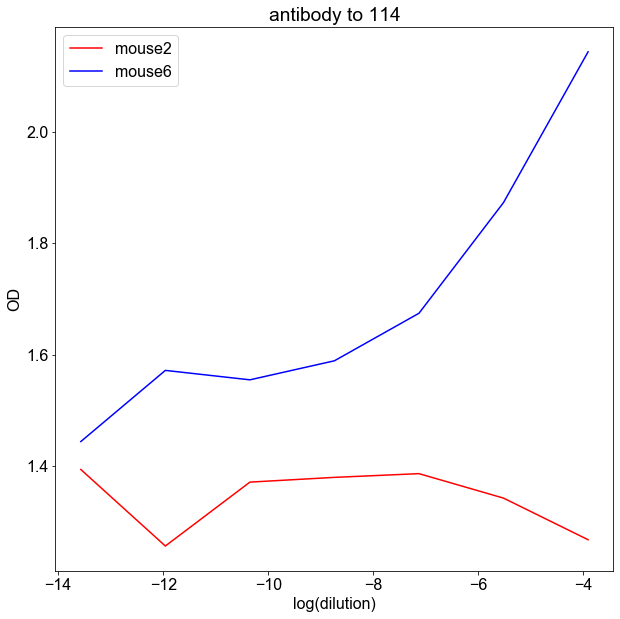

In [35]:
mouse2_rep1=['A3','B3','C3','D3','E3','F3','G3']
mouse2_rep2=['A4','B4','C4','D4','E4','F4','G4']
mouse6_rep1=['A11','B11','C11','D11','E11','F11','G11']
mouse6_rep2=['A12','B12','C12','D12','E12','F12','G12']

dilutions=[(1/50)/5**d for d in range(0,7)]

antigen114mouse2rep1=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse2_rep1])
antigen114mouse2rep1=np.mean(antigen114mouse2rep1,axis=1) # average within each well.
antigen114mouse2rep2=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse2_rep2])
antigen114mouse2rep2=np.mean(antigen114mouse2rep2,axis=1) # average within each well.
antigen114mouse2=0.5*(antigen114mouse2rep1+antigen114mouse2rep2) # average across wells.

antigen114mouse6rep1=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse6_rep1])
antigen114mouse6rep1=np.mean(antigen114mouse6rep1,axis=1) # average within each well.
antigen114mouse6rep2=np.stack([ODwellbyantigen[wellIdx == well, antigenIdx == '114'] for well in mouse6_rep2])
antigen114mouse6rep2=np.mean(antigen114mouse6rep2,axis=1) # average within each well.
antigen114mouse6=0.5*(antigen114mouse6rep1+antigen114mouse6rep2) # average across wells.

plt.figure(figsize=(10,10))
plt.plot(np.log(dilutions),antigen114mouse2,'r', np.log(dilutions),antigen114mouse6,'b')
plt.xlabel('log(dilution)') 
plt.ylabel('OD')
plt.title('antibody to 114')
plt.legend(['mouse2', 'mouse6'])
# antigen114mouse2=np.mean(antigen114mouse2,axis=1)
# antigen114mouse2Replicate=0.5*(antigen114mouse2[0::2]+antigen114mouse2[1::2])
# plt.plot(np.log(dilutions),np.log(antigen114mouse2Replicate))